In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


In [17]:
df = pd.read_csv("../data/processed/features.csv")
df.head()


,user_id,timestamp,amount,time_since_last_txn,txn_count_1h,amount_zscore,device_change_rolling,geo_distance_rolling,risk_momentum,strategy_change,channel,location,is_fraud
0,1,2024-01-03 03:48:02,5.15,NaN,1.0,NaN,0.0,4.250000,NaN,0.0,card,rural,0
1,1,2024-01-04 07:10:57,37.05,98575.0,1.0,0.677090,0.0,5.190000,NaN,0.0,netbanking,semi-urban,0
2,1,2024-01-05 18:50:51,137.87,128394.0,1.0,1.107692,0.0,5.306667,0.371602,0.0,card,rural,0
3,1,2024-01-05 22:04:41,47.32,11630.0,1.0,-0.164491,0.0,5.672500,-0.820200,0.0,netbanking,rural,0
4,1,2024-01-06 06:48:59,93.75,31458.0,1.0,0.557185,0.0,5.952500,0.252694,0.0,card,semi-urban,0


In [18]:
cluster_features = [
    "amount",
    "time_since_last_txn",
    "txn_count_1h",
    "amount_zscore",
    "device_change_rolling",
    "geo_distance_rolling",
    "risk_momentum"
]

X = df[cluster_features].fillna(0)


In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [20]:
dbscan = DBSCAN(
    eps=0.8,
    min_samples=50
)

df["cluster"] = dbscan.fit_predict(X_scaled)


In [21]:
df["cluster"].value_counts()


cluster
 0    45439
-1     3601
 1      909
 2       51
Name: count, dtype: int64

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca_1"] = X_pca[:, 0]
df["pca_2"] = X_pca[:, 1]


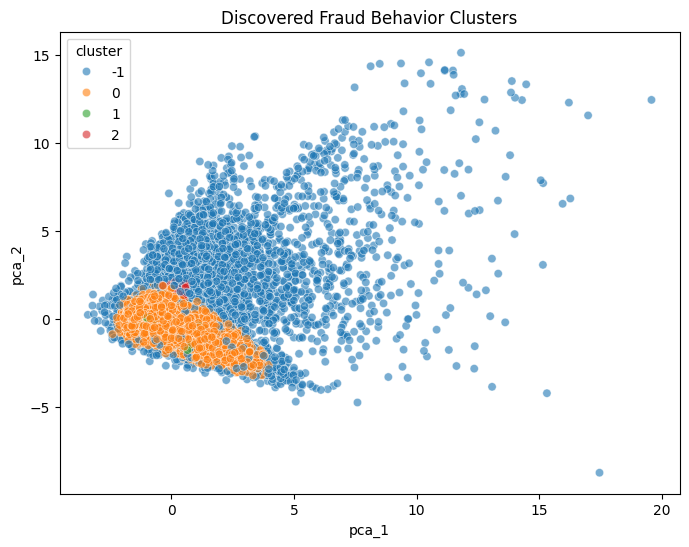

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="tab10",
    alpha=0.6
)
plt.title("Discovered Fraud Behavior Clusters")
plt.show()


In [24]:
cluster_profile = (
    df.groupby("cluster")[cluster_features]
      .mean()
      .round(2)
)

cluster_profile


,amount,time_since_last_txn,txn_count_1h,amount_zscore,device_change_rolling,geo_distance_rolling,risk_momentum
cluster,,,,,,,
-1,324.79,188199.44,1.07,0.34,0.28,9.28,0.09
0,142.49,152540.88,1.00,-0.02,0.00,5.01,-0.00
1,117.81,1772.38,2.00,-0.19,0.00,4.97,-0.07
2,64.39,51213.08,1.00,-0.50,0.20,6.44,-0.15


In [25]:
df["is_fraud"] = df["is_fraud"].astype(int)

fraud_by_cluster = (
    df.groupby("cluster")["is_fraud"]
      .mean()
      .sort_values(ascending=False)
)

fraud_by_cluster


cluster
-1    0.276312
 2    0.019608
 1    0.013201
 0    0.010828
Name: is_fraud, dtype: float64

In [26]:
df["date"] = pd.to_datetime(df["timestamp"]).dt.to_period("M")

cluster_time = (
    df.groupby(["date", "cluster"])
      .size()
      .reset_index(name="count")
)


In [27]:
cluster_time["date"] = cluster_time["date"].dt.to_timestamp()


In [28]:
print("Cluster column exists:", "cluster" in df.columns)
print(df["cluster"].value_counts().head())


Cluster column exists: True
cluster
 0    45439
-1     3601
 1      909
 2       51
Name: count, dtype: int64


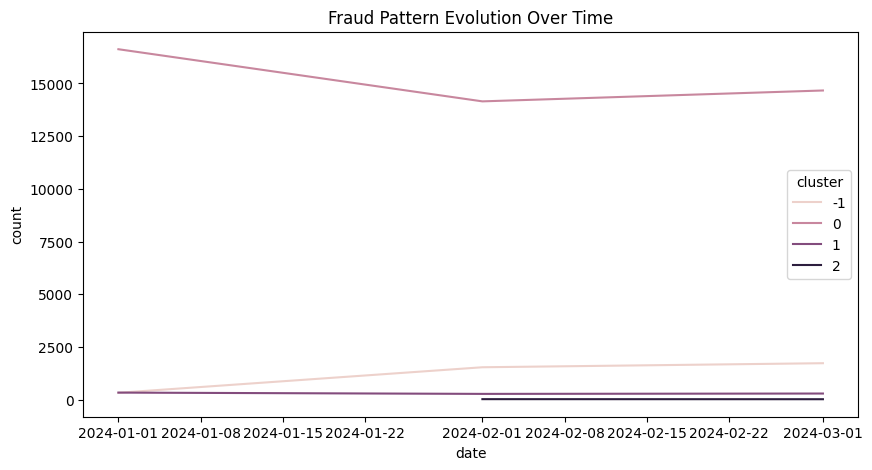

In [29]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=cluster_time,
    x="date",
    y="count",
    hue="cluster"
)
plt.title("Fraud Pattern Evolution Over Time")
plt.show()


In [31]:
clustered_df = df[[
    "user_id",
    "timestamp",
    "amount",
    "time_since_last_txn",
    "txn_count_1h",
    "amount_zscore",
    "device_change_rolling",
    "geo_distance_rolling",
    "risk_momentum",
    "strategy_change",
    "channel",
    "location",
    "is_fraud",
    "cluster"
]].copy()

clustered_df.to_csv("../data/processed/features_with_clusters.csv", index=False)

print("SAVED:", clustered_df.shape)


SAVED: (50000, 14)
